In [100]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3,
                     "axes.grid": True,
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
from network_model import *

In [157]:
from SALib.sample import sobol
from tqdm import tqdm
from sklearn.model_selection import train_test_split


import time
from keras.models import Sequential
from keras.layers import Dense

In [211]:
# define problem
PROBLEM = {
    "num_vars" : 4,
    "names"    : ["wealth", "return", "a", "gamma"],
    "bounds"   : [[0.001, 1000],
                  [1.00,  10.0],
                  [0.1, 2.5],
                  [0.1, 2.5]]
}

# generate Saltelli samples
NUM_SAMPLES = 8192
X = sobol.sample(PROBLEM, NUM_SAMPLES)

In [198]:
consumption = {}
for row in tqdm(X):
    c = minimize(utility, x0=0.5, bounds=[(0.05, 0.95)], args=(row[0], row[1], row[2], row[3])).x[0]
    consumption[tuple(row)] = c

100%|██████████| 81920/81920 [01:34<00:00, 869.77it/s] 


In [212]:
X = np.row_stack(list(consumption.keys()))
y = np.array(list(consumption.values()))

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Create a sequential model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=4))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer with no activation function for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
1544/1544 [==============================] - 1s 934us/step - loss: 0.2300 - val_loss: 0.0155
Epoch 2/100
1544/1544 [==============================] - 1s 935us/step - loss: 0.0162 - val_loss: 0.0088
Epoch 3/100
1544/1544 [==============================] - 2s 1ms/step - loss: 0.0111 - val_loss: 0.0024
Epoch 4/100
1544/1544 [==============================] - 1s 930us/step - loss: 0.0059 - val_loss: 0.0024
Epoch 5/100
1544/1544 [==============================] - 2s 1ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 6/100
1544/1544 [==============================] - 2s 977us/step - loss: 0.0041 - val_loss: 0.0271
Epoch 7/100
1544/1544 [==============================] - 1s 970us/step - loss: 0.0028 - val_loss: 0.0046
Epoch 8/100
1544/1544 [==============================] - 2s 984us/step - loss: 0.0026 - val_loss: 9.0048e-04
Epoch 9/100
1544/1544 [==============================] - 2s 1ms/step - loss: 0.0017 - val_loss: 6.1976e-04
Epoch 10/100
1544/1544 [=============================

1544/1544 [==============================] - 2s 1ms/step - loss: 1.1855e-04 - val_loss: 1.4406e-04
Epoch 75/100
1544/1544 [==============================] - 2s 1ms/step - loss: 1.2213e-04 - val_loss: 4.9495e-05
Epoch 76/100
1544/1544 [==============================] - 1s 924us/step - loss: 1.3061e-04 - val_loss: 2.5881e-05
Epoch 77/100
1544/1544 [==============================] - 1s 910us/step - loss: 1.1457e-04 - val_loss: 1.5679e-04
Epoch 78/100
1544/1544 [==============================] - 1s 951us/step - loss: 1.0779e-04 - val_loss: 0.0010
Epoch 79/100
1544/1544 [==============================] - 1s 915us/step - loss: 1.3470e-04 - val_loss: 6.0932e-05
Epoch 80/100
1544/1544 [==============================] - 2s 998us/step - loss: 1.3728e-04 - val_loss: 1.1082e-04
Epoch 81/100
1544/1544 [==============================] - 2s 992us/step - loss: 9.7219e-05 - val_loss: 1.3982e-04
Epoch 82/100
1544/1544 [==============================] - 1s 937us/step - loss: 9.8001e-05 - val_loss: 2.3996

0.003779987048585636 0.16462552672487002
87


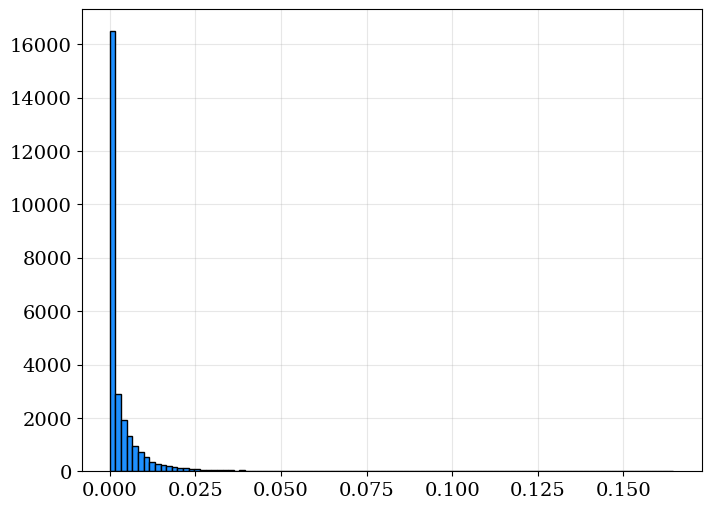

In [234]:
preds = model.predict(X_test)
delta = np.abs(preds - y_test.reshape(-1,1))
print(np.mean(delta), np.max(delta))
print(len([x for x in delta if x > 0.05]))

plt.hist(delta, bins=100, color="dodgerblue", edgecolor='k')
plt.show()

0.00602282494988582 0.1155023992061615


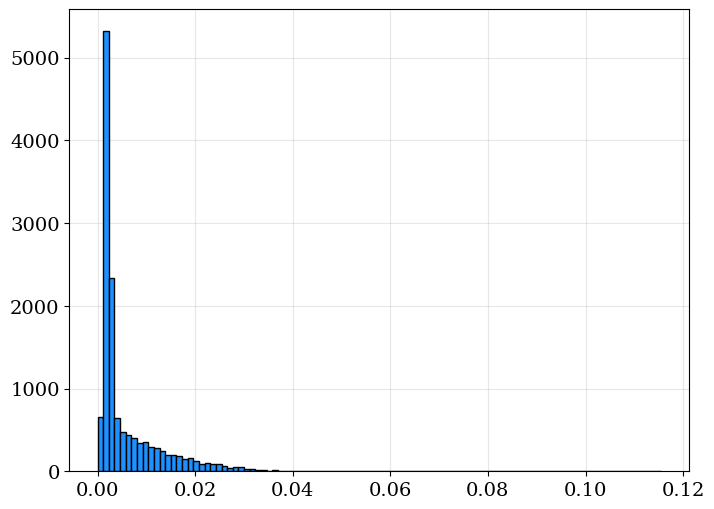

In [167]:
preds = model.predict(X_test)
delta = np.abs(preds - y_test.reshape(-1,1))
print(np.mean(delta), np.max(delta))
print(len([x for x in delta if x > 0.05]))

plt.hist(delta, bins=100, color="dodgerblue", edgecolor='k')
plt.show()

In [216]:
%%timeit
model.predict(X_test[:1000])

37.6 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [219]:
%%timeit
for _ in range(1000):
    c = minimize(utility, x0=0.5, bounds=[(0.05, 0.95)], args=(row[0], row[1], row[2], row[3])).x[0]

1.76 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
37.7 / 1760

0.021420454545454548

In [225]:
37.7 * 50

1885.0000000000002